# Flux.1-dev 网络结构详解

![](https://image-1304830922.cos.ap-shanghai.myqcloud.com/20250302232842466.jpeg)

## 输入准备

根据我们的 Diffusion 三要素理论，在 Sampling 的时候其实只需要确定反向更新公式即可，而 RF 的公式极为简单，Flux.1 也完全是符合我们上一节的内容。

```python
for t_curr, t_prev in zip(timesteps[:-1], timesteps[1:]):
    t_vec = torch.full((img.shape[0],), t_curr, dtype=img.dtype, device=img.device)
    pred = model(
        img=img,
        img_ids=img_ids,
        txt=txt,
        txt_ids=txt_ids,
        y=vec,
        timesteps=t_vec,
        guidance=guidance_vec,
    )

    img = img + (t_prev - t_curr) * pred
```

在模型的输入部分，我们需要确定：

- `img`: latent中的image，`size=[bs, (h*w/16/16), 16*2*2]`
  - 在 VAE 中，压缩比为 16，通道数也为 16
  - 在 VAE 之前做了 patch 化，比例是 2
- `img_ids`: 图像位置编码，`size=[bs, (h*w/16/16), 3]`
  - 位置编码是 3 维的，从 (0,0,0) 到 (0, h/16, w/16)
  - 第 1 维始终是空置的
- `txt`: prompt 的 T5 的 last_hidden_state，`size=[bs, max_length, 4096]`
  - max_length 默认是 512，也可以截断到更小值
- `txt_ids`: 文本位置编码，`size=[bs, max_length, 3]`
  - 全部设置为 (0,0,0)
- `vec`: prompt 的 CLIP 的 pooler_output，`size=[bs, 768]`
  - 是 global feature
- `timesteps`: 当前 timesteps，`size=[bs]`
- `guidance_vec`: 使用的 guidance，`size=[bs]`

### 文本编码器

In [1]:
# 配置一下 huggingface 的环境变量
%env HF_ENDPOINT=https://hf-mirror.com
%env HF_HOME=/data1/cache/huggingface

import os
import re
import time
from dataclasses import dataclass
# from glob import iglob
from torch import Tensor, nn
import math
import torch
# from cuda import cudart
# from fire import Fire
# from transformers import pipeline
from einops import rearrange, repeat
import matplotlib.pyplot as plt
# from flux.sampling import denoise, get_noise, get_schedule, prepare, unpack
# from flux.util import configs, load_ae, load_flow_model

env: HF_ENDPOINT=https://hf-mirror.com
env: HF_HOME=/data1/cache/huggingface


In [2]:
from transformers import CLIPTextModel, CLIPTokenizer, T5EncoderModel, T5Tokenizer

class HFEmbedder(nn.Module):
    def __init__(self, version: str, max_length: int, **hf_kwargs):
        super().__init__()
        self.is_clip = version.startswith("openai")
        self.max_length = max_length
        self.output_key = "pooler_output" if self.is_clip else "last_hidden_state"

        if self.is_clip:
            self.tokenizer: CLIPTokenizer = CLIPTokenizer.from_pretrained(version, max_length=max_length)
            self.hf_module: CLIPTextModel = CLIPTextModel.from_pretrained(version, **hf_kwargs)
        else:
            self.tokenizer: T5Tokenizer = T5Tokenizer.from_pretrained(version, max_length=max_length)
            self.hf_module: T5EncoderModel = T5EncoderModel.from_pretrained(version, **hf_kwargs)

        self.hf_module = self.hf_module.eval().requires_grad_(False)

    def forward(self, text: list[str]) -> Tensor:
        batch_encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            return_length=False,
            return_overflowing_tokens=False,
            padding="max_length",
            return_tensors="pt",
        )

        outputs = self.hf_module(
            input_ids=batch_encoding["input_ids"].to(self.hf_module.device),
            attention_mask=None,
            output_hidden_states=False,
        )
        return outputs[self.output_key]

def load_t5(device: str | torch.device = "cuda", max_length: int = 512) -> HFEmbedder:
    # max length 64, 128, 256 and 512 should work (if your sequence is short enough)
    return HFEmbedder("google/t5-v1_1-xxl", max_length=max_length, torch_dtype=torch.bfloat16).to(device)

def load_clip(device: str | torch.device = "cuda") -> HFEmbedder:
    return HFEmbedder("openai/clip-vit-large-patch14", max_length=77, torch_dtype=torch.bfloat16).to(device)


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_device = torch.device(device)
t5 = load_t5(torch_device, max_length=512)
clip = load_clip(torch_device)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


KeyboardInterrupt: 

In [ ]:
bs = 2
prompt = ["A Hero"]*bs

txt = t5(prompt)
txt_ids = torch.zeros(bs, txt.shape[1], 3).to(torch_device)
y = clip(prompt)

print(txt.size(), y.size(), txt_ids.size())

torch.Size([2, 512, 4096]) torch.Size([2, 768]) torch.Size([2, 512, 3])


### img_ids 图像位置编码

In [ ]:
height = 512
width = 512
# allow for packing and conversion to latent space
height = 16 * (height // 16)
width = 16 * (width // 16)

img = torch.randn(
        bs,
        16,
        # allow for packing
        2 * math.ceil(height / 16),
        2 * math.ceil(width / 16),
        device=device,
        dtype=torch.bfloat16
    )
bs, c, h, w = img.shape

img = rearrange(img, "b c (h ph) (w pw) -> b (h w) (c ph pw)", ph=2, pw=2)

img_ids = torch.zeros(h // 2, w // 2, 3)
img_ids[..., 1] = img_ids[..., 1] + torch.arange(h // 2)[:, None]
img_ids[..., 2] = img_ids[..., 2] + torch.arange(w // 2)[None, :]
img_ids = repeat(img_ids, "h w c -> b (h w) c", b=bs).to(torch_device)

print(img.size(), img_ids.size())

torch.Size([2, 1024, 64]) torch.Size([2, 1024, 3])


### timesteps

In [11]:
from typing import Callable

def time_shift(mu: float, sigma: float, t: Tensor):
    return math.exp(mu) / (math.exp(mu) + (1 / t - 1) ** sigma)


def get_lin_function(
    x1: float = 256, y1: float = 0.5, x2: float = 4096, y2: float = 1.15
) -> Callable[[float], float]:
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return lambda x: m * x + b


def get_schedule(
    num_steps: int,
    image_seq_len: int,
    base_shift: float = 0.5,
    max_shift: float = 1.15,
    shift: bool = True,
) -> list[float]:
    # extra step for zero
    timesteps = torch.linspace(1, 0, num_steps + 1)

    # shifting the schedule to favor high timesteps for higher signal images
    if shift:
        # estimate mu based on linear estimation between two points
        mu = get_lin_function(y1=base_shift, y2=max_shift)(image_seq_len)
        timesteps = time_shift(mu, 1.0, timesteps)

    return timesteps.tolist()

num_steps = 50
timesteps = get_schedule(num_steps, img.shape[1], shift=True)

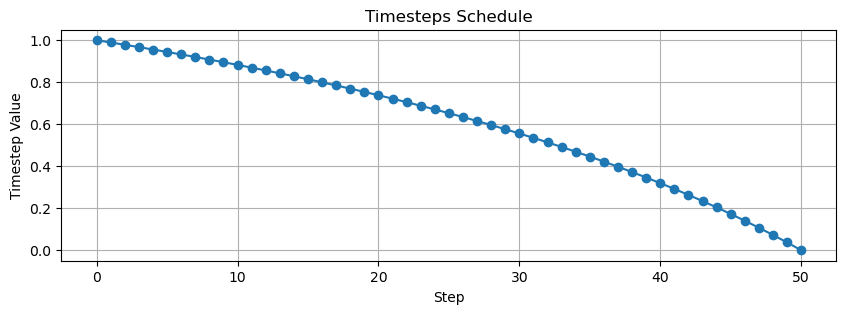

In [7]:
plt.figure(figsize=(10, 3))
plt.plot(timesteps, marker='o', linestyle='-')
plt.title('Timesteps Schedule')
plt.xlabel('Step')
plt.ylabel('Timestep Value')
plt.grid(True)
plt.show()

In [8]:
guidance = 4.0
guidance_vec = torch.full((img.shape[0],), guidance, device=img.device, dtype=img.dtype)
t_vec = timesteps[0].to(torch_device)

torch.Size([2])

为了方便调试，我们可以把输入都保存下来，之后再 load 进来，就不用每次都 load T5 了。

In [4]:
inputs = {
    'img': img,
    'img_ids': img_ids,
    'txt': txt,
    'txt_ids': txt_ids,
    'timesteps': timesteps,
    't_vec': t_vec,
    'y': y,
    'guidance_vec': guidance_vec
}

# 保存张量数据
torch.save(inputs, 'inputs.pt')

In [38]:
print(img.size(), img_ids.size(), txt.size(), txt_ids.size(), t_vec.size(), vec.size(), guidance_vec.size())

torch.Size([2, 1024, 64]) torch.Size([2, 1024, 3]) torch.Size([2, 512, 4096]) torch.Size([2, 512, 3]) torch.Size([2, 768]) torch.Size([2]) torch.Size([2])


## 网络 - 可视化

这里由于 24G 显存加载不进去，我们把 depth 都调小了，因此也没有再加载原参数。仅为探究网络结构的话，参数本身不是很重要。

In [7]:
import torch
from flux.model import Flux, FluxParams

flux_params=FluxParams(
            in_channels=64,
            out_channels=64,
            vec_in_dim=768,
            context_in_dim=4096,
            hidden_size=3072,
            mlp_ratio=4.0,
            num_heads=24,
            depth=2,  # should be 19
            depth_single_blocks=2,  # should be 38
            axes_dim=[16, 56, 56],
            theta=10_000,
            qkv_bias=True,
            guidance_embed=True,
        )

device = "cuda" if torch.cuda.is_available() else "cpu"
torch_device = torch.device(device)
with torch.device(device):
    model = Flux(flux_params).to(torch.bfloat16)


# 如下是加载模型的代码
# from huggingface_hub import hf_hub_download
# from safetensors.torch import load_file as load_sft

# ckpt_path = hf_hub_download("black-forest-labs/FLUX.1-dev", "flux1-dev.safetensors")
# state_dict = load_sft(ckpt_path, device=str(device))

# for name, param in model.named_parameters():
#     if name in state_dict:
#         if state_dict[name].shape != param.shape:
#             print(f"Expanding '{name}' with shape {state_dict[name].shape} to model parameter with shape {param.shape}.")
#             # expand with zeros:
#             expanded_state_dict_weight = torch.zeros_like(param, device=state_dict[name].device)
#             slices = tuple(slice(0, dim) for dim in state_dict[name].shape)
#             expanded_state_dict_weight[slices] = state_dict[name]
#             state_dict[name] = expanded_state_dict_weight

# model.load_state_dict(state_dict, strict=False, assign=True)

In [15]:
# 加载张量数据
inputs = torch.load('inputs.pt')
img = inputs['img']
img_ids = inputs['img_ids']
txt = inputs['txt']
txt_ids = inputs['txt_ids']
timesteps = inputs['timesteps']
t_vec = inputs['t_vec']
y = inputs['y']
guidance_vec = inputs['guidance_vec']

In [8]:
# 测试一下模型是否可以正常运行
pred = model(
    img=img,
    img_ids=img_ids,
    txt=txt,
    txt_ids=txt_ids,
    y=y,
    timesteps=t_vec,
    guidance=guidance_vec,
)

from torchviz import make_dot
# make_dot(pred.mean(), params=dict(model.named_parameters()))

In [17]:
# 导出模型到 onnx，并用 https://netron.app/ 进行可视化
input_names = ["img", "img_ids", "txt", "txt_ids", "timesteps", "y", "guidance"]
output_names = ["output"]
model.eval()

torch.onnx.export(
    model,
    (img, img_ids, txt, txt_ids, t_vec, y, guidance_vec),
    "flux_model.onnx",
    input_names=input_names,
    output_names=output_names,
    opset_version=17,  # 你可以根据需要调整 opset 版本
    do_constant_folding=True,  # 是否执行常量折叠以优化模型
    dynamic_axes={
        "img": {0: "batch_size"},
        "img_ids": {0: "batch_size"},
        "txt": {0: "batch_size"},
        "txt_ids": {0: "batch_size"},
        "timesteps": {0: "batch_size"},
        "y": {0: "batch_size"},
        "guidance": {0: "batch_size"},
        "output": {0: "batch_size"},
    },
)

/root/codes/flux/src/flux/modules/layers.py:166: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  img_q, img_k, img_v = rearrange(img_qkv, "B L (K H D) -> K B H L D", K=3, H=self.num_heads)
/root/codes/flux/src/flux/modules/layers.py:173: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  txt_q, txt_k, txt_v = rearrange(txt_qkv, "B L (K H D) -> K B H L D", K=3, H=self.num_heads)
/root/codes/flux/src/flux/modules/layers.py:232: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect res

In [ ]:
# 使用torchinfo进行可视化
from torchinfo import summary

res = summary(model,
        input_data=[img, img_ids, txt, txt_ids, t_vec, y, guidance_vec],
        col_names=["input_size", "output_size", "num_params", "params_percent"],
        row_settings=["var_names"],
        depth=10,
        verbose=1,
)

Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Param %
Flux (Flux)                                        [2, 1024, 64]             [2, 1024, 64]             --                             --
├─Linear (img_in)                                  [2, 1024, 64]             [2, 1024, 3072]           199,680                     0.02%
├─MLPEmbedder (time_in)                            [2, 256]                  [2, 3072]                 --                             --
│    └─Linear (in_layer)                           [2, 256]                  [2, 3072]                 789,504                     0.08%
│    └─SiLU (silu)                                 [2, 3072]                 [2, 3072]                 --                             --
│    └─Linear (out_layer)                          [2, 3072]                 [2, 3072]                 9,440,256                   0.92%
├─MLPEmbedder (guidance_in)              

## 网络 - 预处理

### img, txt 的 Linear Projection

都投影到了`hidden_size=3072`上，就是一层简单的线性层。

```text
======================================================================================================================================================
Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Param %
======================================================================================================================================================
├─Linear (img_in)                                  [2, 1024, 64]             [2, 1024, 3072]           199,680                     0.02%
├─Linear (txt_in)                                  [2, 512, 4096]            [2, 512, 3072]            12,585,984                  1.23%
======================================================================================================================================================

```

In [ ]:
img = model.img_in(img)
txt = model.txt_in(txt)

### vec <- (y, timesteps, guidance)

`y`, `t_vec`, `guidance_vec` 分别经过了一个 2 层的 MLP，同样是映射到 `hidden_size=3072` 上

```text
======================================================================================================================================================
Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Param %
======================================================================================================================================================
├─MLPEmbedder (time_in)                            [2, 256]                  [2, 3072]                 --                             --
│    └─Linear (in_layer)                           [2, 256]                  [2, 3072]                 789,504                     0.08%
│    └─SiLU (silu)                                 [2, 3072]                 [2, 3072]                 --                             --
│    └─Linear (out_layer)                          [2, 3072]                 [2, 3072]                 9,440,256                   0.92%
├─MLPEmbedder (guidance_in)                        [2, 256]                  [2, 3072]                 --                             --
│    └─Linear (in_layer)                           [2, 256]                  [2, 3072]                 789,504                     0.08%
│    └─SiLU (silu)                                 [2, 3072]                 [2, 3072]                 --                             --
│    └─Linear (out_layer)                          [2, 3072]                 [2, 3072]                 9,440,256                   0.92%
├─MLPEmbedder (vector_in)                          [2, 768]                  [2, 3072]                 --                             --
│    └─Linear (in_layer)                           [2, 768]                  [2, 3072]                 2,362,368                   0.23%
│    └─SiLU (silu)                                 [2, 3072]                 [2, 3072]                 --                             --
│    └─Linear (out_layer)                          [2, 3072]                 [2, 3072]                 9,440,256                   0.92%
======================================================================================================================================================
```

In [34]:
def timestep_embedding(t: Tensor, dim, max_period=10000, time_factor: float = 1000.0):
    """
    Create sinusoidal timestep embeddings.
    :param t: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an (N, D) Tensor of positional embeddings.
    """
    t = time_factor * t
    half = dim // 2
    freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(
        t.device
    )

    args = t[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    if torch.is_floating_point(t):
        embedding = embedding.to(t)
    return embedding

vec = model.time_in(timestep_embedding(t_vec, 256))
vec = vec + model.guidance_in(timestep_embedding(guidance_vec, 256))
vec = vec + model.vector_in(y)

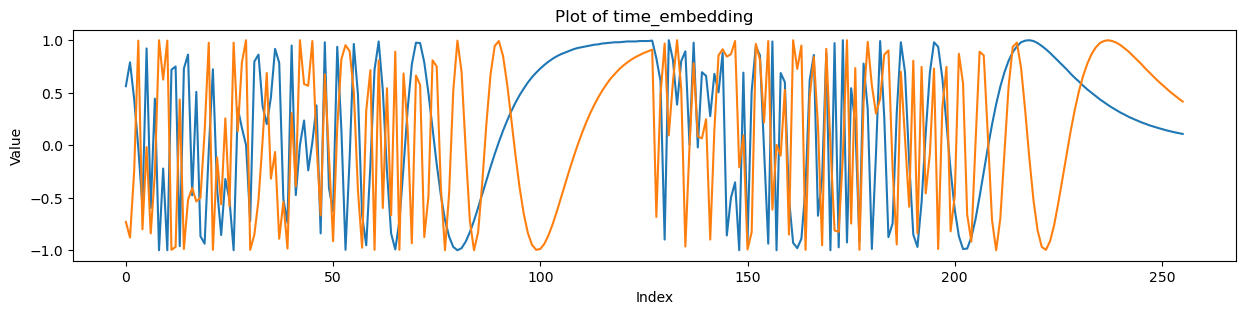

In [58]:
import matplotlib.pyplot as plt

t_vec_embedding = timestep_embedding(t_vec, 256)
guidance_vec_embedding = timestep_embedding(guidance_vec, 256)

plt.figure(figsize=(15, 3))
plt.plot(t_vec_embedding[0].float().cpu().numpy())
plt.plot(guidance_vec_embedding[0].float().cpu().numpy())
plt.title('Plot of time_embedding')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

### 位置编码

In [60]:
ids = torch.cat((txt_ids, img_ids), dim=1)
pe = model.pe_embedder(ids)

In [62]:
def rope(pos: Tensor, dim: int, theta: int) -> Tensor:
    assert dim % 2 == 0
    scale = torch.arange(0, dim, 2, dtype=pos.dtype, device=pos.device) / dim
    omega = 1.0 / (theta**scale)
    out = torch.einsum("...n,d->...nd", pos, omega)
    out = torch.stack([torch.cos(out), -torch.sin(out), torch.sin(out), torch.cos(out)], dim=-1)
    out = rearrange(out, "b n d (i j) -> b n d i j", i=2, j=2)
    return out.float()


class EmbedND(nn.Module):
    def __init__(self, dim: int, theta: int, axes_dim: list[int]):
        super().__init__()
        self.dim = dim
        self.theta = theta
        self.axes_dim = axes_dim

    def forward(self, ids: Tensor) -> Tensor:
        n_axes = ids.shape[-1]
        emb = torch.cat(
            [rope(ids[..., i], self.axes_dim[i], self.theta) for i in range(n_axes)],
            dim=-3,
        )

        return emb.unsqueeze(1)

torch.Size([2, 1536, 3])

In [63]:
pe.size()

torch.Size([2, 1, 1536, 64, 2, 2])